In [ ]:
# example of loading the fashion_mnist dataset
from keras.datasets.fashion_mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)




Using TensorFlow backend.


4423680/4422102 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


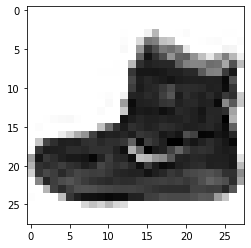

In [ ]:
import matplotlib.pyplot as plt
# plot raw pixel data
plt.imshow(t6, cmap='gray_r')

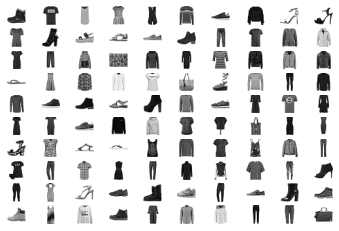

In [ ]:

# example of loading the fashion_mnist dataset
from keras.datasets.fashion_mnist import load_data
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(100):
	# define subplot
	pyplot.subplot(10, 10, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()


In [ ]:
from keras.layers import *
from keras.models import Model
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
  # label input
  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  # scale up to image dimensions with linear activation
  n_nodes = in_shape[0] * in_shape[1]
  li = Dense(n_nodes)(li)
  # reshape to additional channel
  li = Reshape((in_shape[0], in_shape[1], 1))(li)
  # image input
  in_image = Input(shape=in_shape)
  # concat label as a channel
  merge = Concatenate()([in_image, li])
  # downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
  fe = LeakyReLU(alpha=0.2)(fe)
  # downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  # flatten feature maps
  fe = Flatten()(fe)
  # dropout
  fe = Dropout(0.4)(fe)
  # output
  out_layer = Dense(1, activation='sigmoid')(fe)
  # define model
  model = Model([in_image, in_label],  [out_layer] )
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

![alt text](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/05/Plot-of-the-Discriminator-Model-in-the-Conditional-Generative-Adversarial-Network.png)

In [ ]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

![alt text](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/05/Plot-of-the-Generator-Model-in-the-Conditional-Generative-Adversarial-Network.png)

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

![alt text](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/05/Plot-of-the-Composite-Generator-and-Discriminator-Model-in-the-Conditional-Generative-Adversarial-Network.png)

In [ ]:
# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

In [ ]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# create and save a plot of generated images
def save_plot(examples, n, epoch):
  plt.figure(figsize=(10,10))
  # plot images
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(examples[i, :, :, 0], cmap='gray_r')
  plt.tight_layout()
  plt.savefig('gan_generated_image %d.png' %epoch)  
 


In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      # generate 'fake' examples
      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      # prepare points in latent space as input for the generator
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    if i % 2 == 0:
      # generate images
      latent_points, labels = generate_latent_points(100, 100)
      # specify labels
      labels = asarray([x for _ in range(10) for x in range(10)])
      # generate images
      X  = g_model.predict([latent_points, labels])
      # scale from [-1,1] to [0,1]
      X = (X + 1) / 2.0
      # plot the result
      save_plot(X, 10,i)
    # save the generator model
  g_model.save('cgan_generator.h5')

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)

# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim,n_batch=1024)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


>1, 1/58, d1=0.701, d2=0.695 g=0.692
>1, 2/58, d1=0.623, d2=0.699 g=0.688
>1, 3/58, d1=0.544, d2=0.709 g=0.678
>1, 4/58, d1=0.471, d2=0.728 g=0.660
>1, 5/58, d1=0.413, d2=0.758 g=0.636
>1, 6/58, d1=0.364, d2=0.800 g=0.611
>1, 7/58, d1=0.325, d2=0.842 g=0.592
>1, 8/58, d1=0.308, d2=0.861 g=0.598
>1, 9/58, d1=0.300, d2=0.838 g=0.639
>1, 10/58, d1=0.306, d2=0.761 g=0.728
>1, 11/58, d1=0.318, d2=0.653 g=0.848
>1, 12/58, d1=0.318, d2=0.548 g=0.978
>1, 13/58, d1=0.315, d2=0.480 g=1.068
>1, 14/58, d1=0.346, d2=0.473 g=1.051
>1, 15/58, d1=0.319, d2=0.516 g=0.947
>1, 16/58, d1=0.312, d2=0.581 g=0.835
>1, 17/58, d1=0.302, d2=0.648 g=0.753
>1, 18/58, d1=0.258, d2=0.722 g=0.682
>1, 19/58, d1=0.224, d2=0.834 g=0.605
>1, 20/58, d1=0.190, d2=0.950 g=0.541
>1, 21/58, d1=0.185, d2=1.012 g=0.526
>1, 22/58, d1=0.165, d2=0.984 g=0.560
>1, 23/58, d1=0.129, d2=0.877 g=0.645
>1, 24/58, d1=0.129, d2=0.743 g=0.778
>1, 25/58, d1=0.109, d2=0.592 g=0.965
>1, 26/58, d1=0.098, d2=0.465 g=1.156
>1, 27/58, d1=0.082, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


>42, 1/58, d1=0.685, d2=0.663 g=0.749
>42, 2/58, d1=0.687, d2=0.679 g=0.748
>42, 3/58, d1=0.680, d2=0.677 g=0.748
>42, 4/58, d1=0.676, d2=0.676 g=0.746
>42, 5/58, d1=0.668, d2=0.672 g=0.744
>42, 6/58, d1=0.674, d2=0.681 g=0.742
>42, 7/58, d1=0.679, d2=0.684 g=0.739
>42, 8/58, d1=0.673, d2=0.680 g=0.735
>42, 9/58, d1=0.666, d2=0.677 g=0.739
>42, 10/58, d1=0.672, d2=0.674 g=0.747
>42, 11/58, d1=0.673, d2=0.678 g=0.752
>42, 12/58, d1=0.679, d2=0.666 g=0.753
>42, 13/58, d1=0.677, d2=0.665 g=0.749
>42, 14/58, d1=0.688, d2=0.669 g=0.746
>42, 15/58, d1=0.677, d2=0.678 g=0.752
>42, 16/58, d1=0.674, d2=0.668 g=0.748
>42, 17/58, d1=0.674, d2=0.675 g=0.746
>42, 18/58, d1=0.676, d2=0.674 g=0.746
>42, 19/58, d1=0.681, d2=0.677 g=0.749
>42, 20/58, d1=0.674, d2=0.675 g=0.747
>42, 21/58, d1=0.674, d2=0.676 g=0.743
>42, 22/58, d1=0.677, d2=0.687 g=0.743
>42, 23/58, d1=0.682, d2=0.681 g=0.747
>42, 24/58, d1=0.678, d2=0.671 g=0.746
>42, 25/58, d1=0.674, d2=0.671 g=0.755
>42, 26/58, d1=0.676, d2=0.664 g=0